In [16]:
%load_ext autoreload
%autoreload 2

import os
import time
import pdb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

import talib
import mlflow

idx = pd.IndexSlice

# 時間足データを保存する時に使うTimescaleDB用のユーティリティライブラリの設定
from timescaledb_util import *

pg_config = {
    'user': os.environ['POSTGRES_USER'],
    'password': os.environ['POSTGRES_PASSWORD'],
    'host': os.environ['POSTGRES_HOST'],
    'port': os.environ['POSTGRES_PORT'],
    'database': os.environ['POSTGRES_DATABASE_OHLCV_TRADES']
}

# TimescaleDBアクセス用のユーティリティオブジェクトを作成
dbutil = TimeScaleDBUtil(user = pg_config['user'], password = pg_config['password'], host = pg_config['host'], port = pg_config['port'], database = pg_config['database'])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# mlflowの設定
mlflow.set_tracking_uri('http://mlflow:8890')
mlflow.set_experiment('crypto_portfolio_bot')

# 実験のパラメータ
experiment_options = {
    'backtest_from': '2020-01-01 00:00:00+00',
    'backtest_to': '2023-01-01 00:00:00+00',
    'efficientfrontier_type': 'EfficientMeanVariance',
    'objective_type': 'max_quadratic_utility',
    'objective_param': 1.0,
    'download_timebar': False,
    'calculate_topx': False,
    'l2_reg': True,
    'l2_reg_gamma': 0.02,
    'weight_upper_bound': 1,            # 1銘柄のポジション / 全ポジションの絶対値の合計の最大値
    'weight_lower_bound': -1,           # 1銘柄のポジション / 全ポジションの絶対値の合計の最小値
    'rebalance_interval': 24*60*60,      # ポートフォリオリバランス間隔 [秒]
    'execution_period': 18*60*60,      # ポートフォリオリバランス実行期間 [秒]
    'timebar_interval': 5*60,           # タイムバー間隔 [秒]
    'weight_calc_period': 4*7*24*60*60,  # ポートフォリオ計算時のリターン系列の長さ [秒]
    'execution_cost': 0.001,            # トレード手数料
    'initial_usdt_value': 10000.0       # ポートフォリオ計算開始時のUSDT残高
}

# パラメータをmlflowのrunに記録
mlflow.end_run()
for _idx, _value in enumerate(experiment_options):
    mlflow.log_param(_value, experiment_options[_value])

backtest_from: 2020-01-01 00:00:00+00
backtest_to: 2023-01-01 00:00:00+00
efficientfrontier_type: EfficientMeanVariance
objective_type: max_quadratic_utility
objective_param: 1.0
download_timebar: False
calculate_topx: False
l2_reg: True
l2_reg_gamma: 0.02
weight_upper_bound: 1
weight_lower_bound: -1
rebalance_interval: 86400
execution_period: 64800
timebar_interval: 300
weight_calc_period: 2419200
execution_cost: 0.001
initial_usdt_value: 10000.0


In [3]:
import ccxt
from decimal import Decimal
from datetime import timezone, datetime, timedelta

# タイムバーをダウンロードしてTimescaleDBに保存する関数、所定のdict型の配列でダウンロード対象を指定する
def download_timebar(targets):
    for target in targets:
        _exchange = target['exchange']
        _ccxt_client = getattr(ccxt, _exchange)()
        _ccxt_client.load_markets()

        _symbol = target['symbol']
        _interval = target['interval']
        
        since = int(time.mktime(datetime.strptime('2019-01-01 00:00:00+0000', '%Y-%m-%d %H:%M:%S%z').timetuple()) * 1000)

        dbutil.init_timebar_table(_exchange, _symbol, _interval)
        table_name = dbutil.get_timebar_table_name(_exchange, _symbol, _interval)

        df = dbutil.get_latest_timebar(_exchange, _symbol, _interval)
        if type(df) != type(None):
            latest_datetime = df['datetime']
            latest_timestamp = int(latest_datetime.timestamp() * 1000) + 1

            if latest_timestamp > since:
                since = latest_timestamp

        till = int(datetime.now(tz = timezone.utc).timestamp() * 1000)
        origin = since

        with tqdm(total = int(till - origin), initial=0) as _pbar:
            _pbar.set_postfix_str(f'{_exchange}, {_symbol}, {_interval}, row_counts: 0')
            while since <= till:
                time.sleep(ccxt_client.rateLimit / 1000)

                result = ccxt_client.fetch_ohlcv(_symbol, _interval, since = int(since), limit = 1000) # 5min

                df = pd.DataFrame.from_dict(result, dtype=str)
                if len(df) == 0:
                    break

                _to_decimal = lambda x: Decimal(x)

                df.columns = ['datetime', 'open', 'high', 'low', 'close', 'volume']
                df['datetime'] = df['datetime'].apply(lambda x: datetime.fromtimestamp(float(x) / 1000, tz = timezone.utc))
                df['datetime_from'] = df['datetime'] - timedelta(seconds=300) - timedelta(microseconds=1)
                df['open'] = df['open'].apply(_to_decimal)
                df['high'] = df['high'].apply(_to_decimal)
                df['low'] = df['low'].apply(_to_decimal)
                df['close'] = df['close'].apply(_to_decimal)
                df['volume'] = df['volume'].apply(_to_decimal)
                
                # 取引ボリュームの推定を行い記録する
                df['dollar_volume'] = df['volume'] * (df['open'] + df['close'] + df['high'] + df['low']) / Decimal(4)

                nan_columns = ['id', 'id_from', 'dollar_buy_volume', 'dollar_sell_volume', 'dollar_liquidation_volume', 'dollar_liquidation_buy_volume', 'dollar_liquidation_sell_volume', 'dollar_cumsum', 'dollar_buy_cumsum', 'dollar_sell_cumsum']
                for column in nan_columns:
                    df[column] = Decimal(0)

                ret = dbutil.df_to_sql(df=df, schema = table_name, if_exists = 'append')

                since = int(df.iloc[-1]['datetime'].timestamp()*1000) + 1
                _pbar.n = since - origin
                _pbar.set_postfix_str(f'{_exchange}, {_symbol}, {_interval}, row_counts: {len(df)}')
                _pbar.refresh()
            
            _pbar.n = int(till - origin)
            _pbar.refresh()            

In [5]:
# BinanceのUSDT建ての無期限先物をターゲットとして設定する
ccxt_client = getattr(ccxt, 'binanceusdm')()
ccxt_client.load_markets()

targets = []
for symbol in ccxt_client.symbols:
    if '/USDT' in symbol:
        target_5m = {
            'exchange': 'binanceusdm',
            'symbol': symbol,
            'interval': f'{experiment_options["timebar_interval"]/60:.0f}m'
        }
        targets.append(target_5m)

if experiment_options['download_timebar'] == True:
    # USDT建ての無期限先物の5分足をTimescaleDBにダウンロードする
    download_timebar(targets)

100%|██████████| 139/139 [02:44<00:00,  1.18s/it]


In [26]:
# ポートフォリオ構成銘柄の価格系列などを準備する
dfs = []
for _target in tqdm(targets):
    _symbol = _target['symbol']
    _exchange = _target['exchange']
    _interval = _target['interval']
    
    _table_name = dbutil.get_timebar_table_name(_exchange, _symbol, _interval)
    
    _sql = f'SELECT datetime, close, dollar_volume from "{_table_name}" WHERE datetime BETWEEN timestamp \'{experiment_options["backtest_from"]}\' - interval \'{experiment_options["weight_calc_period"]} seconds\' AND timestamp \'{experiment_options["backtest_to"]}\' ORDER BY datetime ASC'
    _df = dbutil.read_sql_query(_sql, index_column = '')
    if len(_df) > 0:
        _df.loc[:, 'symbol'] = _symbol
        _df.dropna(inplace = True)
        dfs.append(_df)
        
# df_portfolioを準備
df_portfolio = pd.concat(dfs)

# df_portfolioにUSDT/USDTを追加
_unique_datetime = df_portfolio['datetime'].unique()
_df_usdt = pd.DataFrame(index=_unique_datetime, columns= ['symbol', 'close', 'dollar_volume']).rename_axis('datetime').reset_index()
_df_usdt.loc[:, 'symbol'] = 'USDT/USDT'
_df_usdt.loc[:, 'close'] = 1.0
_df_usdt.loc[:, 'dollar_volume'] = 0
df_portfolio = pd.concat([df_portfolio, _df_usdt]).set_index(['symbol', 'datetime']).sort_index(level=['symbol', 'datetime'])

# 全銘柄がそろっている最新の時間を抽出し、df_portfolioをスライスする
_latest_datetime = df_portfolio.loc[idx['1000BTTC/USDT', :], :].index[-1][1]
df_portfolio = df_portfolio.loc[idx[:, :f'{_latest_datetime}'], :]

# ポートフォリオ計算に利用するクローズ系列とボリューム系列を準備
_df_close = df_portfolio.reset_index().pivot(index = 'datetime', columns = 'symbol', values='close')
_df_dollar_volume = df_portfolio.reset_index().pivot(index = 'datetime', columns = 'symbol', values='dollar_volume')

In [8]:
# PyPortfolioOptを利用してポートフォリオウェイトを計算

from pypfopt.expected_returns import mean_historical_return, returns_from_prices
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier, EfficientSemivariance
from pypfopt import objective_functions
from pypfopt import plotting

import cvxpy as cp

COV_LENGTH = int(experiment_options['weight_calc_period'] / experiment_options['timebar_interval'])
_df_close = df_portfolio.reset_index().pivot(index = 'datetime', columns = 'symbol', values='close')
array_performance = []

# ウェイト、ポジション、USDTバリュー列を準備する (後々fillnaをして埋めるので、0で埋めてはいけない)
df_portfolio.loc[(slice(None), slice(None)), 'target_weight'] = np.nan
df_portfolio.loc[(slice(None), slice(None)), 'weight'] = np.nan
df_portfolio.loc[(slice(None), slice(None)), 'position'] = np.nan
df_portfolio.loc[(slice(None), slice(None)), 'value'] = np.nan
df_portfolio.loc[(slice(None), slice(None)), 'target_weight_diff_abs'] = 0
df_portfolio.loc[(slice(None), slice(None)), 'fee'] = np.nan

for i in tqdm(range(_df_close.shape[0])):
    # リバランスの時間でだけポートフォリオのウェイトを計算する
    if (_df_close.index[i].value // 10**9) % experiment_options['rebalance_interval'] == 0:
        # ポートフォリオ計算に必要なリターン系列の長さがない場合は、USDT 100%の初期ウェイトを維持する
        _df_close_window = _df_close.iloc[max(0, i - COV_LENGTH + 1):i + 1]
        if i + 1 < COV_LENGTH or len(_df_close_window) == 0:
            df_portfolio.loc[(_df_close.index[i], slice(None)), 'target_weight'] = 0
            df_portfolio.loc[(_df_close.index[i], 'USDT/USDT'), 'target_weight'] = 1
            continue
                
        # ここよりPyPortfolioOptによるポートフォリオウェイト計算
        _mu = mean_historical_return(_df_close_window)
        _historical_returns = returns_from_prices(_df_close_window).fillna(0)
        
        if experiment_options['efficientfrontier_type'] == 'EfficientSemivariance':
            # デフォルトのECOSソルバーではエラーが出るので、SCSを使う
            _ef = EfficientSemivariance(_mu, _historical_returns, solver='SCS', weight_bounds = (experiment_options['weight_lower_bound'], experiment_options['weight_upper_bound']))
        else:
            _S = CovarianceShrinkage(_historical_returns, returns_data=True).ledoit_wolf()
            _ef = EfficientFrontier(_mu, _S, weight_bounds = (experiment_options['weight_lower_bound'], experiment_options['weight_upper_bound']))
        
        if experiment_options['l2_reg'] == True:
            _ef.add_objective(objective_functions.L2_reg, gamma=experiment_options['l2_reg_gamma']) # L2正則化を入れてひとつの銘柄にウェイトが集中するのを防ぐ
        
        # メモ : 負のポジションを許し、ポジションの絶対値の合計を1以下にするためにpyportfoliooptの_make_weight_sum_constraint関数に変更を加えている
        #def _make_weight_sum_constraint(self, is_market_neutral):
        #    ...
        #    else:
        #        # Check negative bound
        #        negative_possible = np.any(self._lower_bounds < 0)
        #        if negative_possible:
        #            # Use norm1 as position constraint
        #            self.add_constraint(lambda w: cp.sum(cp.abs(w)) <= 1)
        #        else: 
        #            self.add_constraint(lambda w: cp.sum(w) == 1)
        #    self._market_neutral = is_market_neutral
        
        # 目標ウェイトを計算する
        if experiment_options['objective_type'] == 'max_quadratic_utility':
            _weights = _ef.max_quadratic_utility(risk_aversion = experiment_options['objective_param'])
        elif experiment_options['objective_type'] == 'max_sharpe':
            _weights = _ef.max_sharpe()
        elif experiment_options['objective_type'] == 'min_volatility':
            if experiment_options['efficientfrontier_type'] == 'EfficientSemivariance':
                _weights = _ef.min_semivariance()
            else:
                _weights = _ef.min_volatility()
        elif experiment_options['objective_type'] == 'efficient_risk':
            if experiment_options['efficientfrontier_type'] == 'EfficientSemivariance':
                _weights = _ef.efficient_risk(target_semideviation = experiment_options['objective_param'])
            else:
                _weights = _ef.efficient_risk(target_volatility = experiment_options['objective_param'])
        elif experiment_options['objective_type'] == 'efficient_return':
            _weights = _ef.efficient_return(target_return = experiment_options['objective_param'])
        
        # ポートフォリオパフォーマンスを記録する
        #_return, _volatility, _sharpe = _ef.portfolio_performance()
        #array_performance.append([_df_close.index[i], _return, _volatility, _sharpe])
        
        # 目標ウェイトを書き込み
        df_portfolio.loc[(_df_close.index[i], slice(None)), 'target_weight'] = 0
        _cleaned_weights = _ef.clean_weights()
        for _key, _value in _cleaned_weights.items():
            df_portfolio.loc[(_df_close.index[i], _key), 'target_weight'] = _value
        
        # 目標ウェイトを合計して1にならない場合があるので、補正を行う
        _target_weights = df_portfolio.loc[(_df_close.index[i], slice(None)), 'target_weight']
        if np.count_nonzero(_target_weights) == 1:
            df_portfolio.loc[(_df_close.index[i], 'USDT/USDT'), 'target_weight'] = df_portfolio.loc[(_df_close.index[i], 'USDT/USDT'), 'target_weight'] + (1 - _target_weights.abs().sum())
        elif _target_weights.abs().sum() > 0:
            df_portfolio.loc[(_df_close.index[i], slice(None)), 'target_weight'] = _target_weights /_target_weights.abs().sum()
        
            
# リバランスタイミングの間にある行の目標ウェイトをffillで埋める
_df_target_weight = df_portfolio.reset_index().pivot(index = 'datetime', columns = 'symbol', values='target_weight')
_df_target_weight.fillna(method='ffill', inplace=True)
_df_target_weight.fillna(method='bfill', inplace=True)
df_portfolio['target_weight'] = _df_target_weight.stack()

# リバランスタイミングの目標ウェイトの差を記録する
_df_target_weight_diff = df_portfolio.loc[(df_portfolio.index.get_level_values('datetime').astype(np.int64) // 10**9 % experiment_options['rebalance_interval'] == 0), :]
_df_target_weight_diff = _df_target_weight_diff.reset_index().pivot(index = 'datetime', columns = 'symbol', values='target_weight').diff().abs()
df_portfolio['target_weight_diff_abs'] = _df_target_weight_diff.stack()

df_portfolio = df_portfolio.sort_index().fillna(0)

100%|██████████| 239251/239251 [04:46<00:00, 834.66it/s] 


In [9]:
# 初期ウェイトと初期ポジションをセットする
df_portfolio.loc[(df_portfolio.index[0], slice(None)), 'target_weight'] = 0.0
df_portfolio.loc[(df_portfolio.index[0], 'USDT/USDT'), 'target_weight'] = 1.0
df_portfolio.loc[(df_portfolio.index[0], slice(None)), 'weight'] = 0.0
df_portfolio.loc[(df_portfolio.index[0], 'USDT/USDT'), 'weight'] = 1.0
df_portfolio.loc[(df_portfolio.index[0], slice(None)), 'value'] = df_portfolio.loc[(df_portfolio.index[0], slice(None)), 'target_weight'] * experiment_options['initial_usdt_value']
df_portfolio.loc[(df_portfolio.index[0], slice(None)), 'position'] = df_portfolio.loc[(df_portfolio.index[0], slice(None)), 'target_weight'] * experiment_options['initial_usdt_value'] / df_portfolio.loc[(df_portfolio.index[0], slice(None)), 'close']

/tmp/ipykernel_3914628/818074397.py:2: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  df_portfolio.loc[(df_portfolio.index[0], slice(None)), 'target_weight'] = 0.0
/tmp/ipykernel_3914628/818074397.py:3: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  df_portfolio.loc[(df_portfolio.index[0], 'USDT/USDT'), 'target_weight'] = 1.0
/tmp/ipykernel_3914628/818074397.py:4: FutureWarning: The behavior of indexing on a MultiIndex with a nested seq

In [10]:
# 5分足でのリバランス処理の計算を行う
from IPython.core.debugger import set_trace

# 各種ピボットテーブルを準備
_df_target_weight = df_portfolio.reset_index().pivot(index = 'datetime', columns = 'symbol', values='target_weight').fillna(0)
_df_weight = df_portfolio.reset_index().pivot(index = 'datetime', columns = 'symbol', values='weight').fillna(0)
_df_close = df_portfolio.reset_index().pivot(index = 'datetime', columns = 'symbol', values='close').fillna(0)
_df_position = df_portfolio.reset_index().pivot(index = 'datetime', columns = 'symbol', values='position').fillna(0).copy()
_df_value = df_portfolio.reset_index().pivot(index = 'datetime', columns = 'symbol', values='value').fillna(0).copy()
_df_fee = df_portfolio.reset_index().pivot(index = 'datetime', columns = 'symbol', values='value').copy()

_df_weight.iloc[:,:] = 0
_df_fee.iloc[:,:] = 0

# リバランスサイクル、執行期間などの定数を5分足何本分かで計算しておく
_rows_execution = int(experiment_options['execution_period'] / experiment_options['timebar_interval'])
_rows_rebalance = int(experiment_options['rebalance_interval'] / experiment_options['timebar_interval'])
_rows_wait_for_execution = _rows_rebalance - _rows_execution

for i in tqdm(range(1, _df_target_weight.shape[0], 1)):
    _step_in_rebalance_cycle = _df_target_weight.index[i].value // 10**9 // experiment_options['timebar_interval'] %_rows_rebalance
    
    # リバランス前のポートフォリオの現在時刻での合計価値は、直前の行のポジションを利用して計算する
    _value_before_rebalance = _df_value.iloc[i-1] + (_df_close.iloc[i] - _df_close.iloc[i-1]) * _df_position.iloc[i-1].abs()
    _value_before_rebalance.fillna(0, inplace=True)
    _value_before_rebalance_abssum = _value_before_rebalance.abs().sum()
        
    if _step_in_rebalance_cycle >= _rows_wait_for_execution:
        # リバランスサイクルの中の執行期間に入っていたらリバランス後のウェイトを求める
        _df_weight.iloc[i] = _df_weight.iloc[i-1] + (_df_target_weight.iloc[i] - _df_weight.iloc[i-1]) / (_rows_rebalance - _step_in_rebalance_cycle) # 1/残りリバランス回数に分割してvalueを調整していく
        
        # リバランス後のウェイトの絶対値の合計が1にならない場合があるので正規化しておく
        # ウェイトが0でない銘柄が1銘柄しかない場合は、割り算で正規化せず、不足分をUSDTに割り当てる
        if np.count_nonzero(_df_weight.iloc[i]) == 1:
            _df_weight.loc[_df_weight.index[i], 'USDT/USDT'] = _df_weight.loc[_df_weight.index[i], 'USDT/USDT'] + (1 - _df_weight.iloc[i].abs().sum())
        elif _df_weight.iloc[i].abs().sum() > 0:
            _df_weight.iloc[i] = _df_weight.iloc[i] / _df_weight.iloc[i].abs().sum()
        
        # リバランス前と後のウェイトの差を計算し、リバランス前の資産合計から手数料を引いておく
        _weight_diff_abs = (_df_weight.iloc[i] - _df_weight.iloc[i-1] ).abs()
        _df_fee.iloc[i] = _value_before_rebalance.abs().sum() * _weight_diff_abs * experiment_options['execution_cost']
        _value_after_fee_abssum = _value_before_rebalance.abs().sum() * (1 - _weight_diff_abs.sum() * experiment_options['execution_cost'])
        
        # 銘柄ごとのバリューを更新
        _df_value.iloc[i] = (_value_after_fee_abssum * _df_weight.iloc[i]).fillna(0)
        
        # ポジションを更新
        _df_position.iloc[i] = _df_value.iloc[i] / _df_close.iloc[i]
        _df_position.iloc[i].fillna(0, inplace=True)
        
    else:
        # 直前のポジションを維持し、最新のクローズ価格でバリューを調整する
        _df_position.iloc[i] = _df_position.iloc[i-1]
        _df_value.iloc[i] = _df_value.iloc[i-1] + (_df_close.iloc[i] - _df_close.iloc[i-1]) * _df_position.iloc[i-1].abs()
        _df_weight.iloc[i] = _df_value.iloc[i] / _df_value.iloc[i].abs().sum()

df_portfolio['position'] = _df_position.stack()
df_portfolio['weight'] = _df_weight.stack()
df_portfolio['value'] = _df_value.stack()
df_portfolio['fee'] = _df_fee.cumsum().stack()
df_portfolio = df_portfolio.sort_index().fillna(0)

100%|██████████| 239250/239250 [16:09<00:00, 246.68it/s]


In [11]:
# パフォーマンス表示用の関数
def visualize_performance(df, array_performance, render_from, render_to, options):
    _fig, _ax = plt.subplots(4, 1, figsize=(12, 24))
    plt.subplots_adjust(wspace=0.2, hspace=0.2)

    # 行のすべてのウェイトが0またはNaNの行を削除してウェイト用のDataFrameを完成させる
    _df_weight = df.loc[(df.index.get_level_values('datetime').astype(np.int64) // 10**9 % options['rebalance_interval'] == 0), :]
    _df_weight = _df_weight.reset_index().pivot(index = 'datetime', columns = 'symbol', values='weight').dropna(how = 'all').fillna(0)
    _df_weight = _df_weight[render_from:render_to]
    
    _df_weight_positive, _df_weight_negative = _df_weight.clip(upper=0), _df_weight.clip(lower=0)
    
    # ポートフォリオウェイトの描画
    _ax[0].set_xlim(_df_weight.index[0], _df_weight.index[-1])
    _ax[0].stackplot(_df_weight_positive.index, _df_weight_positive.T, colors=('tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', 'b', 'g', 'r'), labels=_df_weight_positive.columns)
    _df_weight_negative = _df_weight_negative.rename(columns=lambda x: '_' + x)
    _ax[0].stackplot(_df_weight_negative.index, _df_weight_negative.T, colors=('tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', 'b', 'g', 'r'), labels=_df_weight_negative.columns)
    _ax[0].grid(True)
    _ax[0].legend(bbox_to_anchor=(1.2, 1))
    _ax[0].set_title(f'Portofolio weight')

    # コストを考慮した銘柄リターン表示用のデータフレームを準備
    _df_value = df.loc[(df.index.get_level_values('datetime').astype(np.int64) // 10**9 % options['rebalance_interval'] == 0), :]
    _df_value = _df_value.reset_index().pivot(index = 'datetime', columns = 'symbol', values='value').dropna(how = 'all').fillna(0).abs()
    _df_value = _df_value[render_from:render_to]
    
    _ax[1].set_xlim(_df_value.index[0], _df_value.index[-1])
    _ax[1].stackplot(_df_value.index, _df_value.T, colors=('tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', 'b', 'g', 'r'), labels=_df_value.columns)
    _ax[1].grid(True)
    _ax[1].legend(bbox_to_anchor=(1.2, 1))
    _ax[1].set_title('Portfolio value')
    
    # DD表示
    _df_value['total'] = _df_value.abs().sum(axis=1)
    _df_value['dd_val'] = _df_value['total'].cummax() - _df_value['total']
    _dd_end = _df_value['dd_val'].idxmax()
    _dd_start = _df_value['total'].cummax()[:_dd_end].idxmax()
    _ax[1].plot(_df_value[_dd_start:_dd_end].index, _df_value[_dd_start:_dd_end]['total'], color='r', scalex=False, scaley=False)
    _dd_dict = { 'start': _dd_start.strftime("%m/%d/%Y %H:%M:%S%z"), 'end': _dd_end.strftime("%m/%d/%Y %H:%M:%S%z"), 'dd_value': _df_value.loc[_dd_end, 'dd_val'], 'dd_pct': 1 - (_df_value.loc[_dd_end,'total'] / _df_value.loc[_dd_start, 'total']) }
    
    mlflow.log_metric(key="dd_value", value=_dd_dict['dd_value'])
    mlflow.log_metric(key="dd_pct", value=_dd_dict['dd_pct']*100)
    mlflow.log_metric(key="final_value", value=_df_value.loc[_df_value.index[-1], 'total'])
    
    # 手数料表示用のデータフレームを準備
    _df_fee = df.loc[(df.index.get_level_values('datetime').astype(np.int64) // 10**9 % options['rebalance_interval'] == 0), :]
    _df_fee = _df_fee.reset_index().pivot(index = 'datetime', columns = 'symbol', values='fee').dropna(how = 'all').fillna(0)
    _df_fee = _df_fee[render_from:render_to]
    mlflow.log_metric(key="total fee", value=_df_fee.loc[_df_fee.index[-1], :].sum())
    
    #_ax[2].set_xlim(_df_fee.index[0], _df_fee.index[-1])
    #_ax[2].set_ylim(_ax[1].get_ylim())
    #_ax[2].stackplot(_df_fee.index, _df_fee.T, colors=('tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', 'b', 'g', 'r'), labels=_df_fee.columns)
    #_ax[2].grid(True)
    #_ax[2].set_title('Trade fee')
    #_ax[2].legend(bbox_to_anchor=(1.2, 1))
    
    # ウェイト調整の絶対値用のデータフレームを準備
    _df_target_weight_diff_abs = df.loc[(df.index.get_level_values('datetime').astype(np.int64) // 10**9 % options['rebalance_interval'] == 0), :]
    _df_target_weight_diff_abs = _df_target_weight_diff_abs.reset_index().pivot(index = 'datetime', columns = 'symbol', values='target_weight_diff_abs').dropna(how = 'all').fillna(0)
    _df_target_weight_diff_abs = _df_target_weight_diff_abs[render_from:render_to]
    
    _ax[2].hist(_df_target_weight_diff_abs.sum(axis=1), bins=50, density=True)
    _ax[2].set_title('Weight rebalance amount histogram')
    
    # クローズ系列の描画
    _df_close = df.loc[(df.index.get_level_values('datetime').astype(np.int64) // 10**9 % options['rebalance_interval'] == 0), :]
    _df_close = _df_close.reset_index().pivot(index = 'datetime', columns = 'symbol', values='close').dropna(how = 'all').fillna(0)
    _df_close = _df_close[render_from:render_to]
    _df_close = _df_close / _df_close.replace(0, np.nan).bfill(axis=1).iloc[0, :]
    _df_close.plot(ax=_ax[3])
    _ax[3].grid(True)
    _ax[3].set_title(f'Asset price')
    _ax[3].legend(bbox_to_anchor=(1.2, 1))

    # ポートフォリオ自体のパフォーマンス表示用のデータフレームを準備
    #_df_portfolio_performance = pd.DataFrame(array_performance, columns=['datetime', 'return', 'volatility', 'sharpe']).set_index('datetime', drop = True)

    # ポートフォリオ自体のパフォーマンス描画
    #_df_portfolio_performance[render_from:render_to]['return'].plot(ax=_ax[3], label='return')
    #_df_portfolio_performance[render_from:render_to]['volatility'].plot(ax=_ax[3], label='volatility')
    #_ax[3].grid(True)
    #_ax_sub = _ax[3].twinx()
    #_ax_sub.set_ylabel('sharpe')
    #_df_portfolio_performance[render_from:render_to]['sharpe'].plot(ax=_ax_sub, style='r-', label='sharpe')
    #_ax[3].set_title(f'Portofolio performance')
    #_ax[3].set_ylabel('return / vol')
    #_handle, _label = _ax[3].get_legend_handles_labels()
    #_handle2, _label2 = _ax_sub.get_legend_handles_labels()
    #_ax[3].legend(_handle + _handle2, _label + _label2, bbox_to_anchor=(1.2, 1))

    mlflow.log_figure(_fig, f'portofolio_{render_from}_to_{render_to}.png')
    
    return _fig

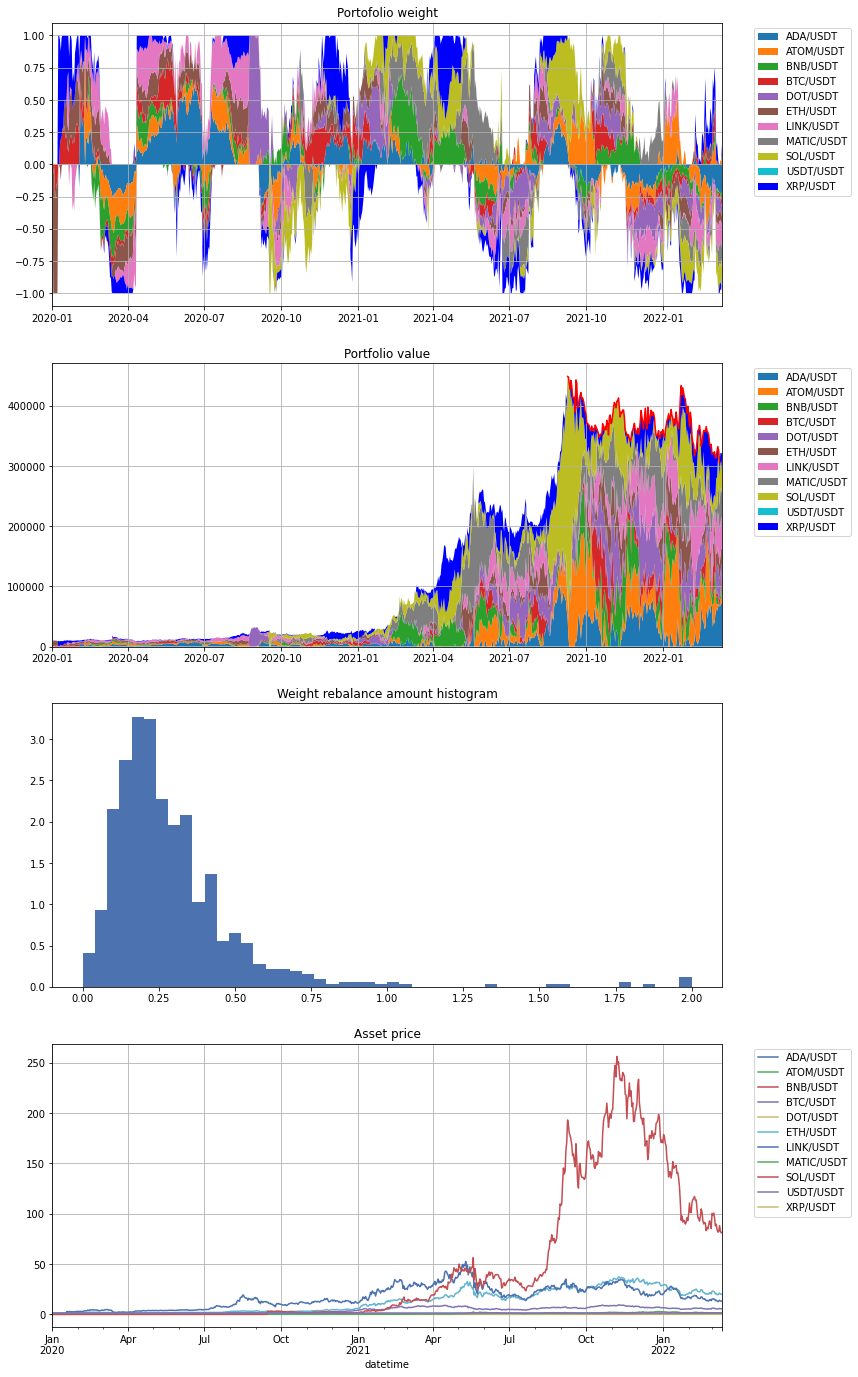

In [12]:
# パフォーマンスを表示
df_portfolio = df_portfolio.sort_index()
df_portfolio.fillna(0, inplace=True)
visualize_performance(df_portfolio, array_performance, experiment_options['backtest_from'], experiment_options['backtest_to'], experiment_options).show()
mlflow.end_run()

In [13]:
df = df_portfolio
options = experiment_options
render_from = options['backtest_from']
render_to = options['backtest_to']

_df_fee = df.loc[(df.index.get_level_values('datetime').astype(np.int64) // 10**9 % options['rebalance_interval'] == 0), :]
_df_fee = _df_fee.reset_index().pivot(index = 'datetime', columns = 'symbol', values='fee').dropna(how = 'all').fillna(0)
_df_fee = _df_fee[render_from:render_to]
_df_fee.iloc[-1].sum()

33977.49106556765